## Benchmark various control algorithms on the dataset

### Importing necessary modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
from time import time
from sklearn.metrics import r2_score, root_mean_squared_error

### Data Preparation

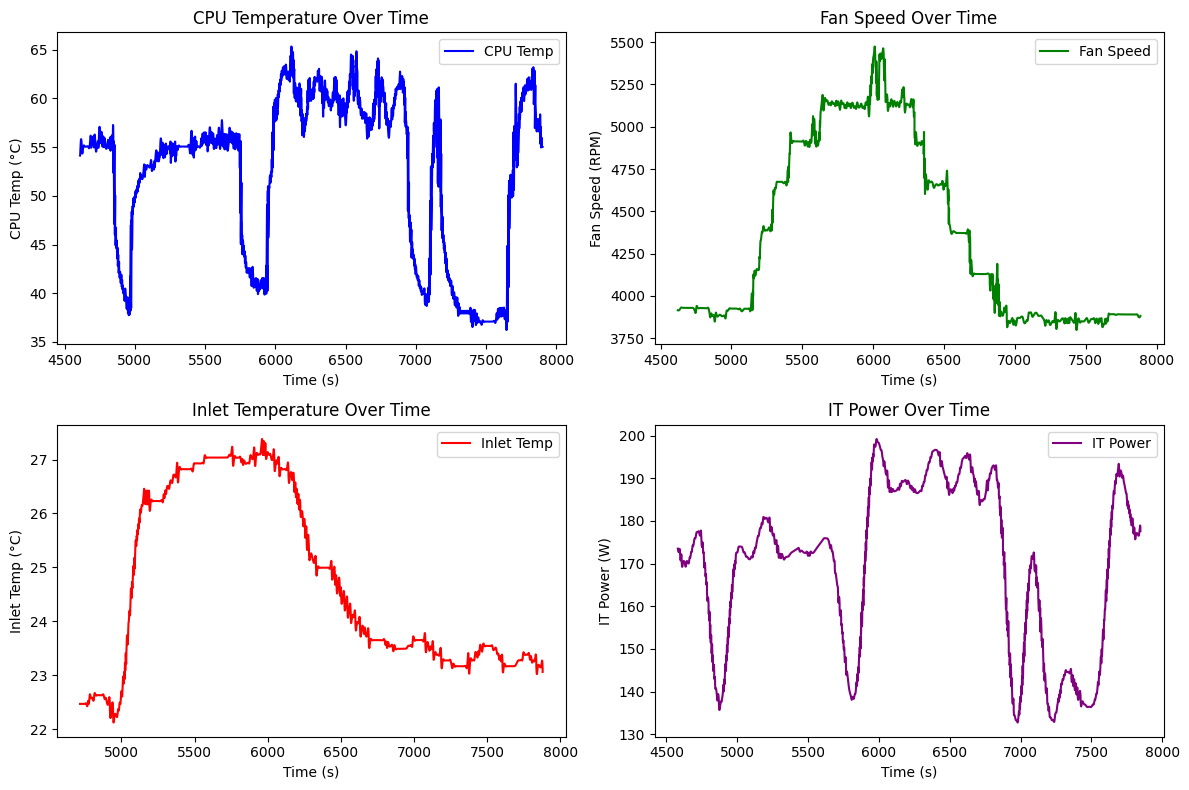

Shape of Final Dataframe = (4255, 5)


In [3]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

def plot_time_series_subplots(cpu_temp_df, fan_speed_df, inlet_temp_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Third subplot - Inlet Temperature
    axs[1, 0].plot(inlet_temp_df[time_col], inlet_temp_df['inlet_temp'], color='red', label='Inlet Temp')
    axs[1, 0].set_title('Inlet Temperature Over Time')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Inlet Temp (°C)')
    axs[1, 0].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, inlet_temp_new, it_power_new, time_col="time")

max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

# combined_df["cpu_temp_change"] = combined_df["cpu_temp"].diff().fillna(0)
# combined_df["it_power_change"] = combined_df["it_power"].diff().fillna(0)
# combined_df["fan_speed_change"] = combined_df["fan_speed"].diff().fillna(0)
# combined_df["cpu_temp_ma3"] = combined_df["cpu_temp"].rolling(window=3).mean().fillna(combined_df["cpu_temp"])
# combined_df["cpu_temp_std3"] = combined_df["cpu_temp"].rolling(window=3).std().fillna(0)

# print(combined_df.head())

df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    # 'cpu_temp_change': MinMaxScaler(),
    # 'it_power_change': MinMaxScaler(),
    # 'fan_speed_change': MinMaxScaler(),
    # 'cpu_temp_ma3': MinMaxScaler(),
    # 'cpu_temp_std3': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

min_fan_speed = 0
max_fan_speed = 8000
scale_beta = 5

df_scaled['fan_speed'] = scale_beta * (df['fan_speed'] - min_fan_speed) / (max_fan_speed - min_fan_speed)

# print(df_scaled.head())

def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    # features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'cpu_temp_change', 'it_power_change', 'fan_speed_change', 'cpu_temp_ma3', 'cpu_temp_std3']
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'fan_speed']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

### 1. On-Off Control

In [12]:
def on_off_control(cpu_temps, T_setpoint=0.6, hysteresis=0.02, fan_on=8000, fan_off=2000):
    """
    cpu_temps: np.array or pd.Series of normalized CPU temperatures (0 to 1)
    Returns a list of fan speed values (same length as cpu_temps)
    """
    fan_speeds = []
    fan_state = False  # Initially off

    for temp in cpu_temps:
        if not fan_state and temp > T_setpoint:
            fan_state = True
        elif fan_state and temp < (T_setpoint - hysteresis):
            fan_state = False

        fan_speeds.append(fan_on if fan_state else fan_off)

    return fan_speeds


In [13]:
# Define last 20% split
split_index = int(len(df_scaled) * 0.8)
df_last_20 = df_scaled.iloc[split_index:].copy()

# Get CPU temps and apply on-off control
cpu_temp_last_20 = df_last_20['cpu_temp'].values
fan_speeds_onoff = on_off_control(cpu_temp_last_20)

# Store the result in the dataframe
df_last_20['fan_speed_onoff'] = fan_speeds_onoff


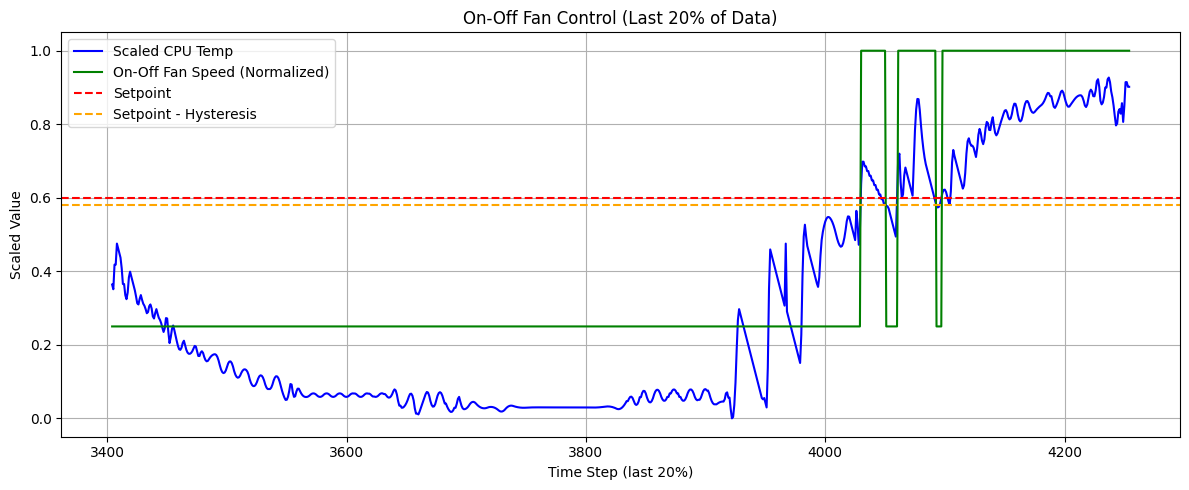

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(df_last_20['cpu_temp'], label='Scaled CPU Temp', color='blue')
plt.plot(df_last_20['fan_speed_onoff'] / max_fan_speed, label='On-Off Fan Speed (Normalized)', color='green')
plt.axhline(0.6, color='red', linestyle='--', label='Setpoint')
plt.axhline(0.58, color='orange', linestyle='--', label='Setpoint - Hysteresis')
plt.title("On-Off Fan Control (Last 20% of Data)")
plt.xlabel("Time Step (last 20%)")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 1) PID Control

In [3]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint, dt=1.0, output_limits=(0, 5)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
        self.min_output, self.max_output = output_limits

    def compute(self, current_value):
        error = self.setpoint - current_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return np.clip(output, self.min_output, self.max_output)

In [10]:
# initialise PID controller with scaled setpoint
setpoint_scaled = 0.5
pid = PIDController(Kp=1.0, Ki=0.1, Kd=0.5, setpoint=setpoint_scaled, dt=1.0)

In [11]:
# Simulate PID control loop
fan_speed_pid = []
cpu_temp_series = df_scaled['cpu_temp'].values
start_idx = int(len(cpu_temp_series) * 0.8)

for t in range(start_idx, len(cpu_temp_series)):
    current_temp = cpu_temp_series[t]
    control_signal = pid.compute(current_temp)
    fan_speed_pid.append(control_signal)

fan_speed_pid_full = [np.nan] * start_idx + fan_speed_pid

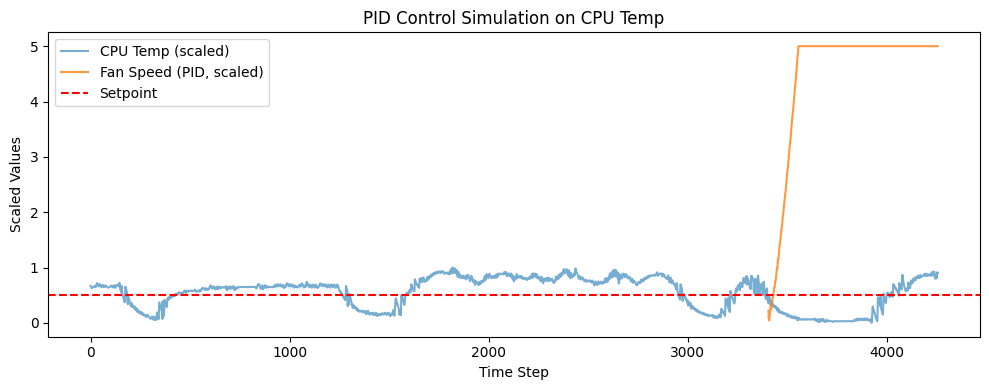

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(df_scaled['cpu_temp'].values, label='CPU Temp (scaled)', alpha=0.6)
plt.plot(fan_speed_pid_full, label='Fan Speed (PID, scaled)', alpha=0.8)
plt.axhline(setpoint_scaled, color='r', linestyle='--', label='Setpoint')
plt.legend()
plt.title("PID Control Simulation on CPU Temp")
plt.xlabel("Time Step")
plt.ylabel("Scaled Values")
# plt.grid(True)
plt.tight_layout()
plt.show()